In [1]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.gridspec as gridspec

# Here are my rc parameters for matplotlib
mpl.rc('font', serif='Helvetica Neue') 
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['figure.figsize'] = 3.2, 2.8
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['axes.linewidth'] = 1.5

# This link shows you how to greyscale a cmap
# https://jakevdp.github.io/PythonDataScienceHandbook/04.07-customizing-colorbars.html

def find(name):
    home = os.path.expanduser("~")
    for root, dirs, files in os.walk(home):
        if name in dirs:
            return os.path.join(root, name)

In [4]:
# First let's find all of our data
whingPath = find('whingdingdilly')
ipyPath = whingPath + '/ipython'
rootPath = ipyPath + '/figures_for_all_data/data_rclust_1.05/data_1.05'

activityRatioPath = rootPath + '/actRatio'
particleFractionPath = rootPath + '/parFrac'
# monodispersePath = dataPath + '/monotxt_01_22_19'
monodispersePath = rootPath + '/mono'
constantRatioPath = rootPath + '/constRat'
cl = '/clusterSizes'
di = '/diams'

# Go to the correct parent directory
os.chdir(rootPath)

# Create a list for the filenames
fileContainer = []
pathContainer = []

# Get files from each source directory
actRatFiles = os.listdir(activityRatioPath + cl)
parFracFiles = os.listdir(particleFractionPath + cl)
monoFiles = os.listdir(monodispersePath + cl)
constFiles = os.listdir(constantRatioPath + cl)


# Create list of sweep identifiers
sweepName = ['Activity Ratio', 'Particle Fraction', 'Monodisperse', 'Constant Activity Ratio']
# Populate the file container
fileContainer.append(actRatFiles)
fileContainer.append(parFracFiles)
fileContainer.append(monoFiles)
fileContainer.append(constFiles)
nSweeps = len(fileContainer)
# Populate the path container
pathContainer.append(activityRatioPath)
pathContainer.append(particleFractionPath)
pathContainer.append(monodispersePath)
pathContainer.append(constantRatioPath)

In [5]:
# Functions to sort my data with
def getFromTxt(fname, first, last):
    """Takes a string, text before and after desired text, outs text between"""
    start = fname.index( first ) + len( first )
    end = fname.index( last, start )
    myTxt = fname[start:end]
    return float(myTxt)
        
def multiSort(arr1, arr2, arr3):
    """Sort an array the slow (but certain) way, returns original indices in sorted order"""
    # Doing this for PeR, PeS, xS in this case
    cpy1 = np.copy(arr1)
    cpy2 = np.copy(arr2)
    cpy3 = np.copy(arr3)
    ind = np.arange(0, len(arr1))
    for i in xrange(len(cpy1)):
        for j in xrange(len(cpy1)):
            # Sort by first variable
            if cpy1[i] > cpy1[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
                
            # If first variable is equal, resort to second variable
            elif cpy1[i] == cpy1[j] and cpy2[i] > cpy2[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
                
            elif cpy1[i] == cpy1[j] and cpy2[i] == cpy2[j] and cpy3[i] > cpy3[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]      
    return ind

def indSort(arr1, arr2):
    """Take sorted index array, use to sort array"""
    # arr1 is array to sort
    # arr2 is index array
    cpy = np.copy(arr1)
    for i in xrange(len(arr1)):
        arr1[i] = cpy[arr2[i]]

In [6]:
# Let's sort our respective lists
for i in xrange(nSweeps):
    paList = []
    pbList = []
    prList = []
    xfList = []
    for j in xrange(len(fileContainer[i])):
        paList.append(getFromTxt(fileContainer[i][j], "pa", "_pb"))
        pbList.append(getFromTxt(fileContainer[i][j], "pb", "_xa"))
        xfList.append(getFromTxt(fileContainer[i][j], "xa", "_ep"))
        xfList[j] = 100.0 - xfList[j]
        # We want to use ratios rounded to nearest 0.05
        try:
            tmpPeR = round(paList[j]/pbList[j] * 2, 1) / 2
        except:
            tmpPeR = 1.0
        prList.append(tmpPeR)
    # Now sort the array of txtFile names
    indArr = multiSort(prList, paList, xfList)
    indSort(fileContainer[i], indArr)
    
# Use this to check the parameter sort
# for i in xrange(len(fileContainer[1])):
#     print(fileContainer[1][i])

In [7]:
# Read the data for each parameter study into a pandas dataframe
all_sims = []
for i in xrange(nSweeps):
    all_sims.append([])
    os.chdir(pathContainer[i])
    for j in xrange(len(fileContainer[i])):
        df = pd.read_csv(fileContainer[i][j], sep='\s+', header=0)
        all_sims[i].append(df)
        
# Go back to the source folder (save figures here)
os.chdir(dataPath)        

# If you want to see what your data looks like
# display(all_sims[0][0])

# Get the name of each of the headers in the dataframes
list(all_sims[0][0])

['Timestep',
 'Gas_A',
 'Gas_B',
 'Gas_tot',
 'Dense_A',
 'Dense_B',
 'Dense_tot',
 'Lc_numA',
 'Lc_numB',
 'Lg_clust',
 'MCS',
 'sigALL',
 'sigAA',
 'sigAB',
 'sigBB',
 'phiEff',
 'lg_clustA',
 'tot_clustA',
 'LC_density',
 'DP_density',
 'GP_density']

In [8]:
# Make sure all data is chronilogical
def chkSort(array):
    """Make sure array is chronilogical"""
    for i in xrange(len(array)-2):
        if array[i] > array[i+1]:
            print("{} is not greater than {} for indices=({},{})").format(array[i+1], array[i], i, i+1)
            return False
    return True

# Check to see if timesteps are in order
for i in xrange(nSweeps):
    for j in xrange(len(fileContainer[i])):
        myBool = chkSort(all_sims[i][j]['Timestep'])
        if myBool is False:
            print("{} is not chronilogically sorted!").format(fileContainer[i][j])
            exit(1)
        else:
            print("{} sorted... ").format(fileContainer[i][j])

diam_pa0_pb500_xa90_ep82.txt sorted... 
diam_pa0_pb500_xa70_ep82.txt sorted... 
diam_pa0_pb500_xa50_ep82.txt sorted... 
diam_pa0_pb500_xa30_ep82.txt sorted... 
diam_pa50_pb500_xa90_ep82.txt sorted... 
diam_pa50_pb500_xa70_ep82.txt sorted... 
diam_pa50_pb500_xa50_ep82.txt sorted... 
diam_pa50_pb500_xa30_ep82.txt sorted... 
diam_pa100_pb500_xa90_ep82.txt sorted... 
diam_pa100_pb500_xa70_ep82.txt sorted... 
diam_pa100_pb500_xa50_ep82.txt sorted... 
diam_pa100_pb500_xa30_ep82.txt sorted... 
diam_pa150_pb500_xa90_ep82.txt sorted... 
diam_pa150_pb500_xa70_ep82.txt sorted... 
diam_pa150_pb500_xa50_ep82.txt sorted... 
diam_pa150_pb500_xa30_ep82.txt sorted... 
diam_pa200_pb500_xa90_ep82.txt sorted... 
diam_pa200_pb500_xa70_ep82.txt sorted... 
diam_pa200_pb500_xa50_ep82.txt sorted... 
diam_pa200_pb500_xa30_ep82.txt sorted... 
diam_pa250_pb500_xa90_ep82.txt sorted... 
diam_pa250_pb500_xa70_ep82.txt sorted... 
diam_pa250_pb500_xa50_ep82.txt sorted... 
diam_pa250_pb500_xa30_ep82.txt sorted... 
diam

diam_pa130_pb433_xa70_ep71.txt sorted... 
diam_pa130_pb433_xa50_ep71.txt sorted... 
diam_pa130_pb433_xa30_ep71.txt sorted... 
diam_pa140_pb466_xa70_ep76.txt sorted... 
diam_pa140_pb466_xa50_ep76.txt sorted... 
diam_pa140_pb466_xa30_ep76.txt sorted... 
diam_pa150_pb500_xa70_ep82.txt sorted... 
diam_pa150_pb500_xa30_ep82.txt sorted... 
diam_pa10_pb20_xa70_ep5.txt sorted... 
diam_pa10_pb20_xa50_ep5.txt sorted... 
diam_pa10_pb20_xa30_ep5.txt sorted... 
diam_pa20_pb40_xa70_ep8.txt sorted... 
diam_pa20_pb40_xa50_ep8.txt sorted... 
diam_pa20_pb40_xa30_ep8.txt sorted... 
diam_pa30_pb60_xa70_ep11.txt sorted... 
diam_pa30_pb60_xa50_ep11.txt sorted... 
diam_pa30_pb60_xa30_ep11.txt sorted... 
diam_pa40_pb80_xa70_ep14.txt sorted... 
diam_pa40_pb80_xa50_ep14.txt sorted... 
diam_pa40_pb80_xa30_ep14.txt sorted... 
diam_pa50_pb100_xa70_ep18.txt sorted... 
diam_pa50_pb100_xa50_ep18.txt sorted... 
diam_pa50_pb100_xa30_ep18.txt sorted... 
diam_pa60_pb120_xa70_ep21.txt sorted... 
diam_pa60_pb120_xa50_ep21.

In [9]:
# Add a column to the all_sims dataframe for number of clusters (of threshold size):
for i in xrange(nSweeps):
    for j in xrange(len(fileContainer[i])):
        # New column for number of clusters
        all_sims[i][j]['nClust'] = all_sims[i][j]['Dense_tot'] / all_sims[i][j]['MCS']
        # Ger rid of NaN in favor of 0
        all_sims[i][j].fillna(0, inplace=True)

# display(all_sims[0][0])
list(all_sims[0][0])

['Timestep',
 'Gas_A',
 'Gas_B',
 'Gas_tot',
 'Dense_A',
 'Dense_B',
 'Dense_tot',
 'Lc_numA',
 'Lc_numB',
 'Lg_clust',
 'MCS',
 'sigALL',
 'sigAA',
 'sigAB',
 'sigBB',
 'phiEff',
 'lg_clustA',
 'tot_clustA',
 'LC_density',
 'DP_density',
 'GP_density',
 'nClust']

In [10]:
# Function that will sort wrt one variable
def singleSort(arr):
    for i in xrange(len(arr)):
        for j in xrange(len(arr)):
            if arr[i] < arr[j] and i > j:
                arr[i], arr[j] = arr[j], arr[i]
                
# Function to get conversion from timesteps to Brownian time
def computeTauPerTstep(epsilon):
    # This is actually indpendent of runtime :)
#     sigma = 1.0
#     threeEtaPiSigma = 1.0
#     runFor = 200
#     tauBrown = 1.0
#     tauLJ = ((sigma**2) * threeEtaPiSigma) / epsilon
#     dt = 0.00001 * tauLJ
#     simLength = runFor * tauBrown
#     totTsteps = int(simLength / dt)
#     tstepPerTau = int(totTsteps / float(simLength))
    kBT = 1.0
    tstepPerTau = int(epsilon / (kBT * 0.00001))
    return tstepPerTau

def theoryDenom(xF, peS, peF):
    xF /= 100.0
    xS = 1.0 - xF
    return 4.0 * ((xS * peS) + (xF * peF))

def theory(xF, peS, peF):
    kappa = 4.05
    xF /= 100.0
    xS = 1.0 - xF
    return ((3.0 * (np.pi**2) * kappa) / (4.0 * ((xS * peS) + (xF * peF))))

# Make an additional frame that gives total number of particles, and simulation parameters
params = []
for i in xrange(nSweeps):
    paramList = []
    for j in xrange(len(fileContainer[i])):
        partAll = all_sims[i][j]['Gas_tot'][0]
        partA = all_sims[i][j]['Gas_A'][0]
        partB = all_sims[i][j]['Gas_B'][0]
        pa = getFromTxt(fileContainer[i][j], "pa", "_pb")
        pb = getFromTxt(fileContainer[i][j], "pb", "_xa")
        xa = getFromTxt(fileContainer[i][j], "xa", "_ep")
        xf = 100.0 - xa
        ep = getFromTxt(fileContainer[i][j], "ep", ".txt")
        converT = computeTauPerTstep(ep)
        mytheoryDenom = theoryDenom(xf, pa, pb)
#         #Monodisperse slow
#         if xf == 0:
#             mytheory = theory(xf, pa, pb)
        if (pa != 0 and xa != 0) or (pb != 0 and xf != 0): 
            mytheory = theory(xf, pa, pb)
        else:
            mytheory = 0.0

        # This is monodisperse
        if pb == 0 and xa == 100:
            prat = 1.0

        # This is active/passive
        elif pb == 0 and xa != 100:
            prat = 0.0

        # Everything else
        else:
            # Round to the nearest tenths place
            prat = round(float(pa)/float(pb) * 2, 1) / 2

        paramList.append((partAll, partA, partB, pa, pb, xf, prat, ep, converT, mytheoryDenom, mytheory))

    # Put the data for this parameter sweep into it's own dataframe
    params.append(pd.DataFrame(paramList, columns=['partAll',
                                                  'partA',
                                                  'partB',
                                                  'peA',
                                                  'peB',
                                                  'xF',
                                                  'peR',
                                                  'eps',
                                                  'brownTime',
                                                  'theoryDenom',
                                                  'theory'])
                 )
    pd.set_option('display.max_rows', 2)
    display(params[i])

,partAll,partA,partB,peA,peB,xF,peR,eps,brownTime,theoryDenom,theory
0,100000,90000,10000,0.0,500.0,10.0,0.0,82.0,8199999,200.0,0.599578
...,...,...,...,...,...,...,...,...,...,...,...
42,100000,50000,50000,500.0,500.0,50.0,1.0,82.0,8199999,2000.0,0.059958


,partAll,partA,partB,peA,peB,xF,peR,eps,brownTime,theoryDenom,theory
0,100000,90000,10000,0.0,500.0,10.0,0.0,82.0,8199999,200.0,0.599578
...,...,...,...,...,...,...,...,...,...,...,...
93,100000,70000,30000,500.0,500.0,30.0,1.0,82.0,8199999,2000.0,0.059958


,partAll,partA,partB,peA,peB,xF,peR,eps,brownTime,theoryDenom,theory
0,100000,100000,0,0.0,500.0,0.0,0.0,82.0,8199999,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
10,100000,100000,0,500.0,500.0,0.0,1.0,82.0,8199999,2000.0,0.059958


,partAll,partA,partB,peA,peB,xF,peR,eps,brownTime,theoryDenom,theory
0,50000,25000,25000,10.0,100.0,50.0,0.1,18.0,1799999,220.0,0.545071
...,...,...,...,...,...,...,...,...,...,...,...
163,50000,25000,25000,150.0,166.0,50.0,0.9,28.0,2800000,632.0,0.189740


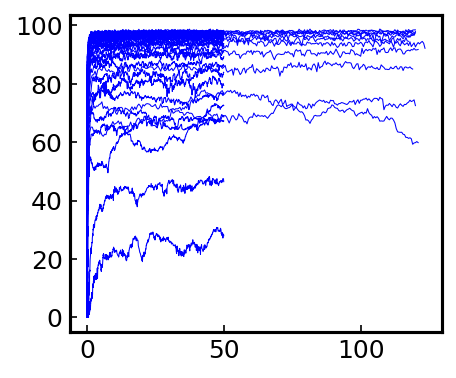

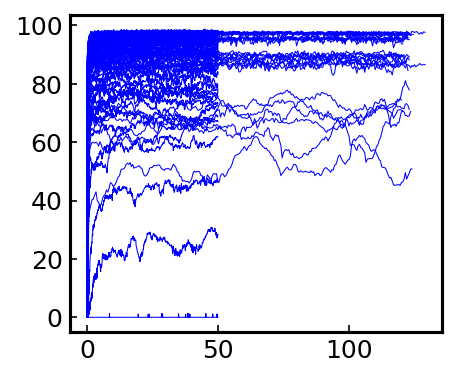

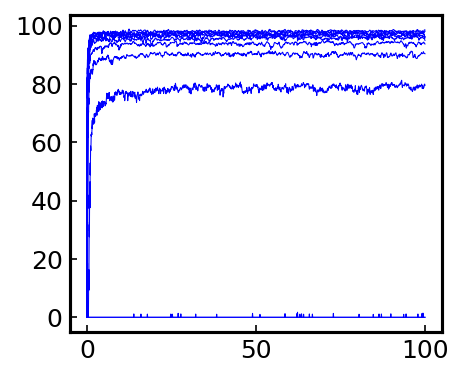

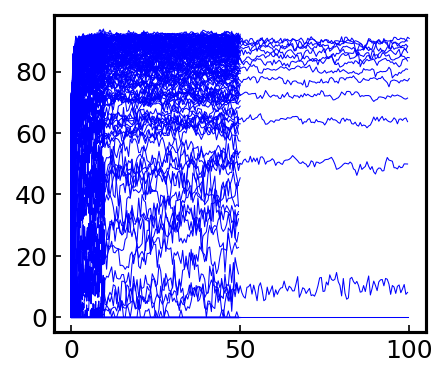

In [11]:
# Make sure I haven't messed up my data
for i in xrange(nSweeps):
    for j in xrange(len(fileContainer[i])):
        plt.plot(all_sims[i][j]['Timestep'][:] / params[i]['brownTime'][j],
                 all_sims[i][j]['Dense_A'][:] / params[i]['partA'][j] * 100.0,
                 c='b',
                 label=str(params[i]['peR'][j]))
    plt.show()

Number of textfiles before delete: 43
Number of all_sims dataframes before delete: 43
Params rows before delete: 43
Number of textfiles after delete: 43
Number of all_sims dataframes after delete: 43
Params rows after delete: 43


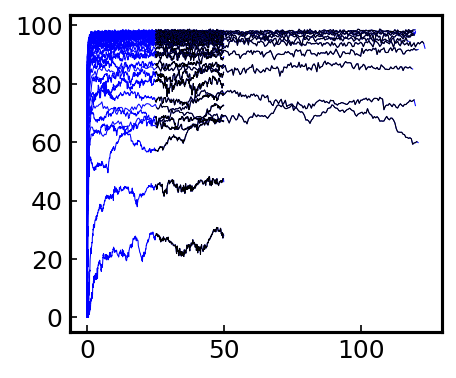

Number of textfiles before delete: 94
Number of all_sims dataframes before delete: 94
Params rows before delete: 94
Number of textfiles after delete: 94
Number of all_sims dataframes after delete: 94
Params rows after delete: 94


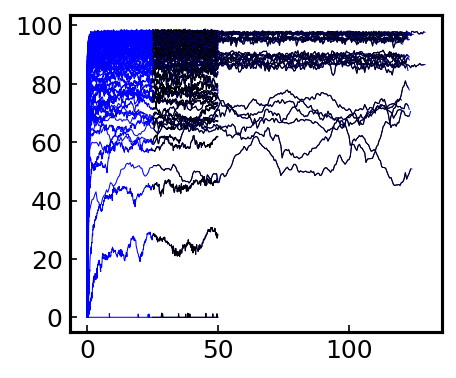

Number of textfiles before delete: 11
Number of all_sims dataframes before delete: 11
Params rows before delete: 11
Number of textfiles after delete: 11
Number of all_sims dataframes after delete: 11
Params rows after delete: 11


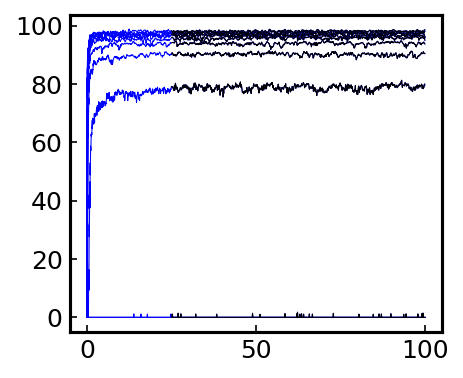

Number of textfiles before delete: 164
Number of all_sims dataframes before delete: 164
Params rows before delete: 164
Number of textfiles after delete: 159
Number of all_sims dataframes after delete: 159
Params rows after delete: 159


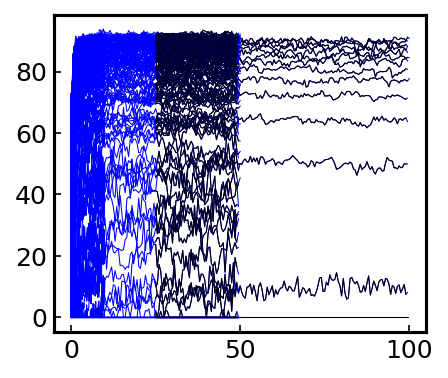

In [12]:
# We should average past a specific time, not an index number...
ssStartTime = 25.0
ssStartInd = [ [] for i in xrange(nSweeps) ]
badFiles = [ [] for i in xrange(nSweeps) ]

# Figure out what we should use for steady-state
for i in xrange(nSweeps):
    for j in xrange(len(fileContainer[i])):
        if all_sims[i][j]['Timestep'].iloc[-1] / params[i]['brownTime'][j] >= ssStartTime:
            for k in xrange(len(all_sims[i][j]['Timestep'])):
                if all_sims[i][j]['Timestep'][k] / params[i]['brownTime'][j] >= ssStartTime:
                    ssStartInd[i].append(k)
                    break
        else:
            badFiles[i].append(j)

# Delete rows of dataframe
for i in xrange(nSweeps):
    # Remove these indices from: txtFiles, all_sims, params
    print("Number of textfiles before delete: {}").format(len(fileContainer[i]))
    print("Number of all_sims dataframes before delete: {}").format(len(all_sims[i]))
    print("Params rows before delete: {}").format(len(params[i]['partAll']))
    if badFiles[i]:
        # You have to reverse the order so that you don't mess up your indexing
        for myindex in sorted(badFiles[i], reverse=True):
            del fileContainer[i][myindex]
            del all_sims[i][myindex]
            params[i].drop(params[i].index[myindex], inplace=True)  
    print("Number of textfiles after delete: {}").format(len(fileContainer[i]))
    print("Number of all_sims dataframes after delete: {}").format(len(all_sims[i]))
    print("Params rows after delete: {}").format(len(params[i]['partAll']))

    # You have to reindex the dataframe
    params[i].index = range(len(params[i]['partAll']))

    # Visual check to see if this is the appropriate time window for steady-state
    for j in xrange(len(fileContainer[i])):
        plt.plot(all_sims[i][j]['Timestep'][:] / params[i]['brownTime'][j],
                 all_sims[i][j]['Dense_A'][:] / params[i]['partA'][j] * 100.0,
                 c='b',
                 label=str(params[i]['peR'][j]))
        plt.plot(all_sims[i][j]['Timestep'][ssStartInd[i][j]:-1] / params[i]['brownTime'][j],
                 all_sims[i][j]['Dense_A'][ssStartInd[i][j]:-1] / params[i]['partA'][j] * 100.0,
                 c='k')
    plt.show()

In [14]:
# Now get time-based steady state values
all_SS = []
all_stdDev = []
all_var = []
for i in xrange(nSweeps):
    # Make list of steady state column headers
    headers = list(all_sims[i][0])
    headers.remove('Timestep')
    SS = pd.DataFrame(columns=headers)
    stdDev = pd.DataFrame(columns=headers)
    var = pd.DataFrame(columns=headers)
    # Initialize dataframes
    for j in xrange(len(fileContainer[i])):
        SS.loc[j] = [0] * len(headers)
        stdDev.loc[j] = [0] * len(headers)
        var.loc[j] = [0] * len(headers)

    # Make dataframe of steady-state data
    for j in xrange(len(fileContainer[i])):
        # Loop through each column (aside from tstep column)
        for k in range(1, len(all_sims[i][j].iloc[1])):
            # Compute mean of data after steady-state time (25tb) in jth column of ith file
            avg = np.mean(all_sims[i][j].iloc[ssStartInd[i][j]:-1, k])
            SS[headers[k-1]][j] = avg
            # Compute the standard deviation and variance in this data
            stdDevor = np.std(all_sims[i][j].iloc[ssStartInd[i][j]:-1, k])
            stdDev[headers[k-1]][j] = stdDevor
            var[headers[k-1]][j] = stdDevor ** 2

    # Normalize by number of particles
    for j in xrange(len(fileContainer[i])):
        if params[i]['partA'][j] != 0:
            SS['Gas_A'][j] /= params[i]['partA'][j]
            SS['Dense_A'][j] /= params[i]['partA'][j]
            SS['Lc_numA'][j] /= params[i]['partA'][j]
            # Now my standard error is a percentage
            stdDev['Gas_A'][j] /= params[i]['partA'][j]
            stdDev['Dense_A'][j] /= params[i]['partA'][j]
            stdDev['Lc_numA'][j] /= params[i]['partA'][j]
            var['Gas_A'][j] /= params[i]['partA'][j]
            var['Dense_A'][j] /= params[i]['partA'][j]
            var['Lc_numA'][j] /= params[i]['partA'][j]

        if params[i]['partB'][j] != 0:
            SS['Gas_B'][j] /= params[i]['partB'][j]
            SS['Dense_B'][j] /= params[i]['partB'][j]
            SS['Lc_numB'][j] /= params[i]['partB'][j]
            stdDev['Gas_B'][j] /= params[i]['partB'][j]
            stdDev['Dense_B'][j] /= params[i]['partB'][j]
            stdDev['Lc_numB'][j] /= params[i]['partB'][j]
            var['Gas_B'][j] /= params[i]['partB'][j]
            var['Dense_B'][j] /= params[i]['partB'][j]
            var['Lc_numB'][j] /= params[i]['partB'][j]

    SS['Gas_tot'][:] /= params[i]['partAll'][:]
    SS['Dense_tot'][:] /= params[i]['partAll'][:] 
    SS['Lg_clust'][:] /= params[i]['partAll'][:] 
    SS['MCS'][:] /= params[i]['partAll'][:]
    stdDev['Gas_tot'][:] /= params[i]['partAll'][:]
    stdDev['Dense_tot'][:] /= params[i]['partAll'][:] 
    stdDev['Lg_clust'][:] /= params[i]['partAll'][:] 
    stdDev['MCS'][:] /= params[i]['partAll'][:]
    var['Gas_tot'][:] /= params[i]['partAll'][:]
    var['Dense_tot'][:] /= params[i]['partAll'][:] 
    var['Lg_clust'][:] /= params[i]['partAll'][:] 
    var['MCS'][:] /= params[i]['partAll'][:]

    SS['Gas_A'][:] *= 100.0
    SS['Gas_B'][:] *= 100.0
    SS['Gas_tot'][:] *= 100.0
    SS['Dense_A'][:] *= 100.0
    SS['Dense_B'][:] *= 100.0
    SS['Dense_tot'][:] *= 100.0
    SS['Lc_numA'][:] *= 100.0
    SS['Lc_numB'][:] *= 100.0
    SS['Lg_clust'][:] *= 100.0
    SS['MCS'][:] *= 100.0
    stdDev['Gas_A'][:] *= 100.0
    stdDev['Gas_B'][:] *= 100.0
    stdDev['Gas_tot'][:] *= 100.0
    stdDev['Dense_A'][:] *= 100.0
    stdDev['Dense_B'][:] *= 100.0
    stdDev['Dense_tot'][:] *= 100.0
    stdDev['Lc_numA'][:] *= 100.0
    stdDev['Lc_numB'][:] *= 100.0
    stdDev['Lg_clust'][:] *= 100.0
    stdDev['MCS'][:] *= 100.0
    var['Gas_A'][:] *= 100.0
    var['Gas_B'][:] *= 100.0
    var['Gas_tot'][:] *= 100.0
    var['Dense_A'][:] *= 100.0
    var['Dense_B'][:] *= 100.0
    var['Dense_tot'][:] *= 100.0
    var['Lc_numA'][:] *= 100.0
    var['Lc_numB'][:] *= 100.0
    var['Lg_clust'][:] *= 100.0
    var['MCS'][:] *= 100.0
    
    # Put these values into the modular container
    all_SS.append(SS)
    all_stdDev.append(stdDev)
    all_var.append(var)
    # Delete these and loop through next parameter sweep
    del SS
    del stdDev
    del var
    
pd.set_option('display.max_rows', 6)
display(all_SS[0])

,Gas_A,Gas_B,Gas_tot,Dense_A,Dense_B,Dense_tot,Lc_numA,Lc_numB,Lg_clust,MCS,...,sigAA,sigAB,sigBB,phiEff,lg_clustA,tot_clustA,LC_density,DP_density,GP_density,nClust
0,74.3107,46.0849,71.4881,25.6893,53.9151,28.5119,16.9288,34.5992,18.6958,12.925,...,1.00076,1.00061,1.00053,0.6,14704.3,22425.1,1.27,1.27,0.658795,3.56252
1,36.5184,10.1041,28.5941,63.4816,89.8959,71.4059,61.8456,87.4451,69.5254,60.2797,...,1.0004,1.00038,1.00032,0.6,54645.4,56123.4,1.27,1.27,0.381526,1.42571
2,31.2066,5.41386,18.3102,68.7934,94.5861,81.6898,67.8256,93.4688,80.6472,69.3523,...,1.00029,1.00025,1.00023,0.6,63372.6,64191.9,1.27,1.27,0.273979,1.32461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,1.96376,1.91032,1.95842,98.0362,98.0897,98.0416,98.0032,98.0552,98.0084,96.8611,...,1.00006,1.00006,1.00001,0.6,76984.1,77010.2,1.27,1.27,0.0363855,1.0241
41,2.19969,2.1908,2.19702,97.8003,97.8092,97.803,97.7202,97.7275,97.7224,95.2663,...,1.00006,1.00006,1.00004,0.6,76759.2,76822.5,1.27,1.27,0.0406024,1.05221
42,2.07494,2.07651,2.07572,97.9251,97.9235,97.9243,97.8609,97.8592,97.86,96.3718,...,1.00004,1.00005,1.00006,0.6,76866.9,76917.3,1.27,1.27,0.0387302,1.03175
